In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygeohash as gh
%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import ensemble

In [55]:
df = pd.read_csv('data.csv')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount
0,2,2015-07-18 11:25:58,2015-07-18 11:43:47,1,7.21,-73.862762,40.769028,1.0,N,-73.949203,40.722584,1,22.5,0.0,0.5,4.66,0.00,0.3,27.96
1,1,2015-03-15 12:50:01,2015-03-15 13:23:35,1,10.80,-73.870926,40.773727,NaN,N,-73.988228,40.765694,1,34.5,0.0,0.5,8.10,5.33,0.3,48.73
2,2,2015-04-30 12:25:44,2015-04-30 13:03:51,1,4.28,-73.978180,40.762341,NaN,N,-74.008911,40.710789,1,24.5,0.0,0.5,2.50,0.00,0.3,27.80
3,2,2015-05-28 08:47:56,2015-05-28 09:26:08,1,18.47,-73.776711,40.645302,NaN,N,-73.843422,40.852852,1,51.0,0.0,0.5,7.00,5.54,0.3,64.34
4,1,2015-06-20 19:36:17,2015-06-20 20:10:49,1,15.50,-73.777054,40.644947,NaN,Y,-73.946800,40.725021,1,44.5,0.0,0.5,9.06,0.00,0.3,54.36


/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


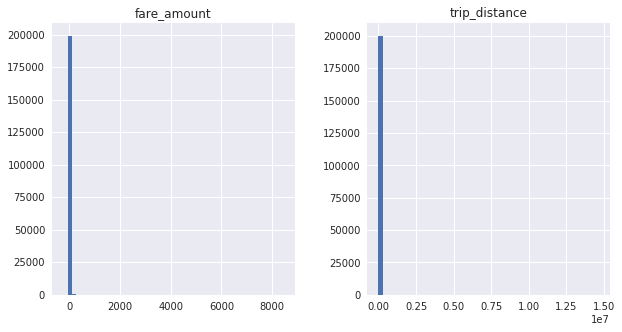

In [4]:
# Check the distribution of trip_distance and fare_amount
df[['trip_distance','fare_amount']].hist(figsize = (10,5), bins=50);

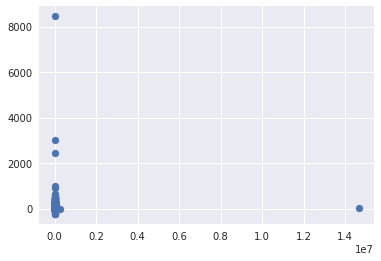

In [5]:
plt.scatter(df['trip_distance'], df['fare_amount']);

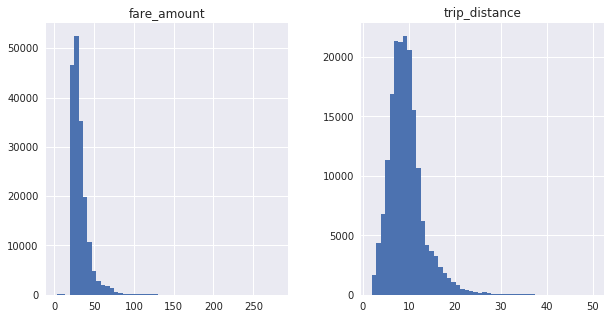

In [6]:
# Remove those rows with very low or very high fare_amount or trip_distance
df_filtered = df[(df['trip_distance'] >= 2) & (df['trip_distance'] <= 50) & (df['fare_amount'] >= 3) & (df['fare_amount'] <=300)]
df_filtered[['trip_distance','fare_amount']].hist(figsize = (10,5), bins=50);

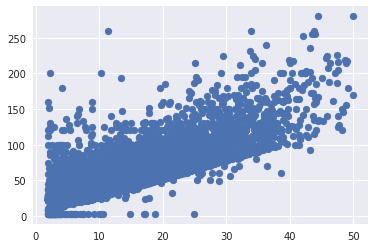

In [7]:
plt.scatter(df_filtered['trip_distance'], df_filtered['fare_amount']);

In [8]:
# Add trip_duration and year
df_filtered['pickup_datetime'] = pd.to_datetime(df_filtered['pickup_datetime'])
df_filtered['dropoff_datetime'] = pd.to_datetime(df_filtered['dropoff_datetime'])
df_filtered['trip_duration'] = (df_filtered['dropoff_datetime']-df_filtered['pickup_datetime']).dt.total_seconds()/60
df_filtered['year'] = df_filtered['pickup_datetime'].dt.year

/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

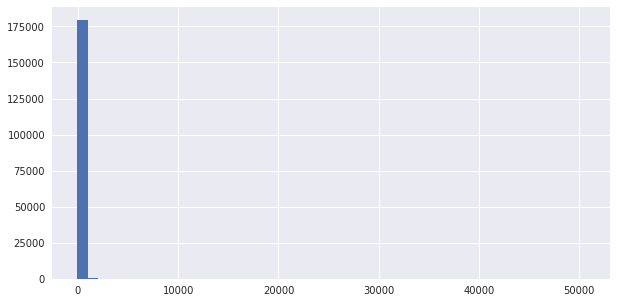

In [9]:
df_filtered['trip_duration'].hist(figsize = (10,5), bins=50);

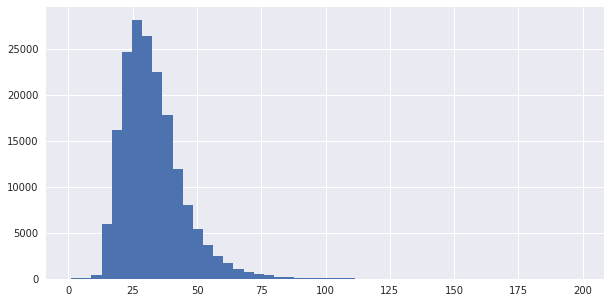

In [10]:
df_filtered = df_filtered[(df_filtered['trip_duration'] <= 200) & (df_filtered['trip_duration'] > 1)]
df_filtered['trip_duration'].hist(figsize = (10,5), bins=50);

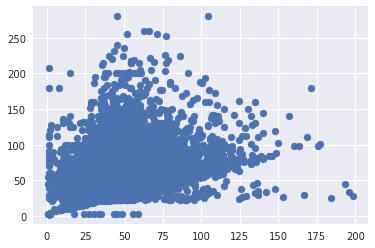

In [11]:
plt.scatter(df_filtered['trip_duration'], df_filtered['fare_amount']);

In [12]:
def train_test_split(X, y):
    X_train = X.loc[X['year'] == 2015].drop('year', axis=1)
    y_train = y.loc[y['year'] == 2015].drop('year', axis=1).values.ravel()
    X_test = X.loc[X['year'] == 2016].drop('year', axis=1)
    y_test = y.loc[y['year'] == 2016].drop('year', axis=1).values.ravel()
    return X_train, y_train, X_test, y_test
  
def model_results(X_train, y_train, X_test, y_test, model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print("----Training Data results (2015 data set)----")
    print("RMSE: ${:.1f}".format(mean_squared_error(y_train, y_train_pred)**0.5))
    print("R2: {:.2f}\n".format(r2_score(y_train, y_train_pred)))
    
    print("----Test Data results (2016 data set)----")
    print("RMSE: ${:.1f}".format(mean_squared_error(y_test, y_test_pred)**0.5))
    print("R2: {:.2f}\n".format(r2_score(y_test, y_test_pred)))

In [13]:
# Create Train and Test sets
y = df_filtered[['fare_amount', 'year']]
X = df_filtered[['trip_distance', 'trip_duration', 'year']]
X_train, y_train, X_test, y_test = train_test_split(X, y)

In [14]:
X_train.head()

,trip_distance,trip_duration
0,7.21,17.816667
1,10.80,33.566667
2,4.28,38.116667
3,18.47,38.200000
4,15.50,34.533333


In [15]:
# Simple bivariate model
lm = LinearRegression().fit(X_train,y_train)
model_results(X_train, y_train, X_test, y_test, lm)

----Training Data results (2015 data set)----
RMSE: $5.6
R2: 0.79

----Test Data results (2016 data set)----
RMSE: $5.5
R2: 0.81



# Simple Linear model results
- Simple bivariate linear model has a high RMSE as 5.5
- Try multivariate linear model to reduce the RMSE

# Feature Engineering
Add in features as below
1. Pickup month
2. Pickup day of the week
3. Pickup hour of the day
4. Lattitude difference
5. Longitude difference
6. Geohashed pickup location (idea from internet)
7. Geohashed dropoff location (idea from internet)

In [16]:
df_filtered['day'] = df_filtered['pickup_datetime'].dt.day
df_filtered['month'] = df_filtered['pickup_datetime'].dt.month
df_filtered['day_of_week'] = df_filtered['pickup_datetime'].dt.weekday_name
df_filtered['hour_of_day'] = df_filtered['pickup_datetime'].dt.hour
df_filtered['lat_dif'] = df_filtered['pickup_latitude'] - df_filtered['dropoff_latitude']
df_filtered['lon_dif'] = df_filtered['pickup_longitude'] - df_filtered['dropoff_longitude']
df_filtered['pickup_geohash']=df_filtered.apply(lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=5), axis=1)
df_filtered['dropoff_geohash']=df_filtered.apply(lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=5), axis=1)

df_filtered.head()

,Unnamed: 0,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,...,trip_duration,year,day,month,day_of_week,hour_of_day,lat_dif,lon_dif,pickup_geohash,dropoff_geohash
0,0,2,2015-07-18 11:25:58,2015-07-18 11:43:47,1,7.21,-73.862762,40.769028,1.0,N,...,17.816667,2015,18,7,Saturday,11,0.046444,0.086441,dr5rz,dr5rt
1,1,1,2015-03-15 12:50:01,2015-03-15 13:23:35,1,10.80,-73.870926,40.773727,NaN,N,...,33.566667,2015,15,3,Sunday,12,0.008034,0.117302,dr5rz,dr5ru
2,2,2,2015-04-30 12:25:44,2015-04-30 13:03:51,1,4.28,-73.978180,40.762341,NaN,N,...,38.116667,2015,30,4,Thursday,12,0.051552,0.030731,dr5ru,dr5re
3,3,2,2015-05-28 08:47:56,2015-05-28 09:26:08,1,18.47,-73.776711,40.645302,NaN,N,...,38.200000,2015,28,5,Thursday,8,-0.207550,0.066711,dr5x1,dr72r
4,4,1,2015-06-20 19:36:17,2015-06-20 20:10:49,1,15.50,-73.777054,40.644947,NaN,Y,...,34.533333,2015,20,6,Saturday,19,-0.080074,0.169746,dr5x1,dr5rt


In [17]:
df_filtered.shape

(179231, 30)

In [18]:
df_filtered = df_filtered[df_filtered['lat_dif'].notnull() & df_filtered['lon_dif'].notnull()]
df_filtered.shape

(135568, 30)

In [36]:
y = df_filtered[['fare_amount', 'year']]
X = df_filtered[['passenger_count', 'trip_distance', 'trip_duration', 'year', 'month', 'day_of_week', 'hour_of_day', 'lat_dif', 'lon_dif', 'pickup_geohash']]
X_encoded = pd.get_dummies(X, columns=['month', 'day_of_week', 'hour_of_day', 'pickup_geohash'])

In [37]:
X_train, y_train, X_test, y_test = train_test_split(X_encoded, y)

In [38]:
# Multivariate Model
lm = LinearRegression().fit(X_train,y_train)
model_results(X_train, y_train, X_test, y_test, lm)

----Training Data results (2015 data set)----
RMSE: $5.3
R2: 0.81

----Test Data results (2016 data set)----
RMSE: $5.1
R2: 0.83



# Feature Engineering results
- Through trial and error found that adding dropoff_geohash is leading to overfit so drop this from the features list 
- Multivariate linear model has improved the RMSE to 5.1
- Since the Training Data still has high RMSE, the linear model is suffering from high Bias
- Try Boosting models to improve the Bias

# Advanced Models

In [39]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}
gbr = ensemble.GradientBoostingRegressor(**params)
gbr.fit(X_train, y_train)
model_results(X_train, y_train, X_test, y_test, gbr)

----Training Data results (2015 data set)----
RMSE: $3.9
R2: 0.90

----Test Data results (2016 data set)----
RMSE: $4.0
R2: 0.89



In [40]:
def importances(X_train, model):
    # Plot feature importance
    feature_importance = model.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[::-1][:20][::-1]
    names = [X_train.columns[index] for index in sorted_idx]
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(10,10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, names)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.tight_layout()
    plt.show()

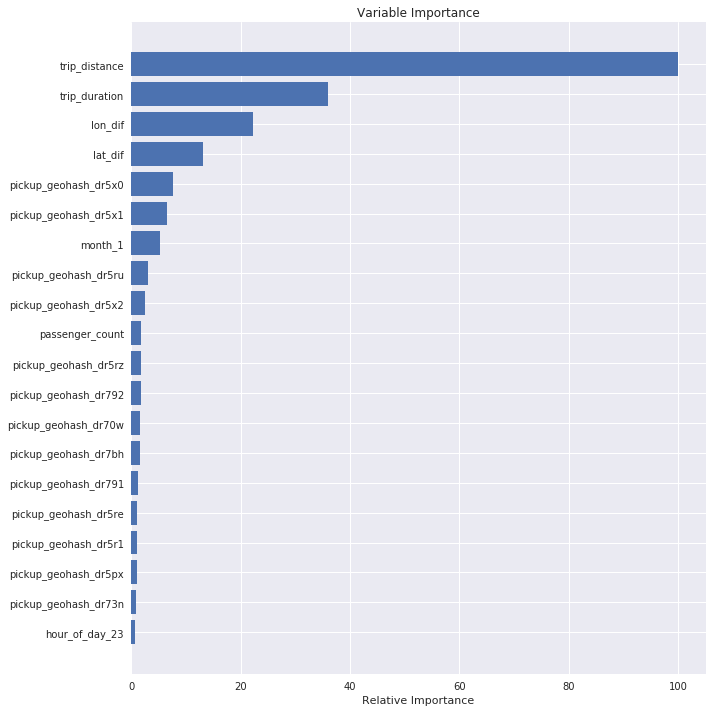

In [42]:
importances(X_train, gbr)

# Advanced Model results
- Boosting model has significantly improved the RMSE to 4
- Try Data Augmentation to drive RMSE < 3

# Data Augmentation
- Weather might play a role in taxi fare
- Big Query has weather data
- Choose 1 station within new york to augment weather data to original dataset

In [56]:
weather_df = pd.read_csv('weather_data.csv')
weather_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
weather_df.head()

,year,month,day,min_temp,max_temp,prcp,sndp
0,2016,4,3,35.1,61.0,0.24,999.9
1,2016,3,21,33.1,50.0,0.14,999.9
2,2016,8,5,70.0,86.0,0.00,999.9
3,2016,10,31,46.9,60.1,0.76,999.9
4,2016,3,25,44.1,73.0,0.00,999.9


In [57]:
df_augmented = df_filtered.merge(weather_df, how='inner', on = ['year', 'month', 'day'])
df_augmented.head()

,Unnamed: 0,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,...,day_of_week,hour_of_day,lat_dif,lon_dif,pickup_geohash,dropoff_geohash,min_temp,max_temp,prcp,sndp
0,0,2,2015-07-18 11:25:58,2015-07-18 11:43:47,1,7.21,-73.862762,40.769028,1.0,N,...,Saturday,11,0.046444,0.086441,dr5rz,dr5rt,68.0,86.0,0.0,999.9
1,1015,1,2015-07-18 05:45:28,2015-07-18 06:10:13,1,14.00,-74.011505,40.702785,1.0,N,...,Saturday,5,0.103264,0.077049,dr5re,dr5qf,68.0,86.0,0.0,999.9
2,1425,1,2015-07-18 00:22:24,2015-07-18 00:50:07,1,6.10,-74.008011,40.741375,1.0,N,...,Saturday,0,-0.062584,-0.044930,dr5rg,dr72h,68.0,86.0,0.0,999.9
3,3924,1,2015-07-18 21:58:53,2015-07-18 22:16:51,1,7.50,-73.970001,40.785599,1.0,N,...,Saturday,21,-0.071918,-0.036736,dr72h,dr72m,68.0,86.0,0.0,999.9
4,4093,1,2015-07-18 11:19:37,2015-07-18 11:46:54,2,10.00,-73.862732,40.769016,1.0,N,...,Saturday,11,0.047882,0.124977,dr5rz,dr5rs,68.0,86.0,0.0,999.9


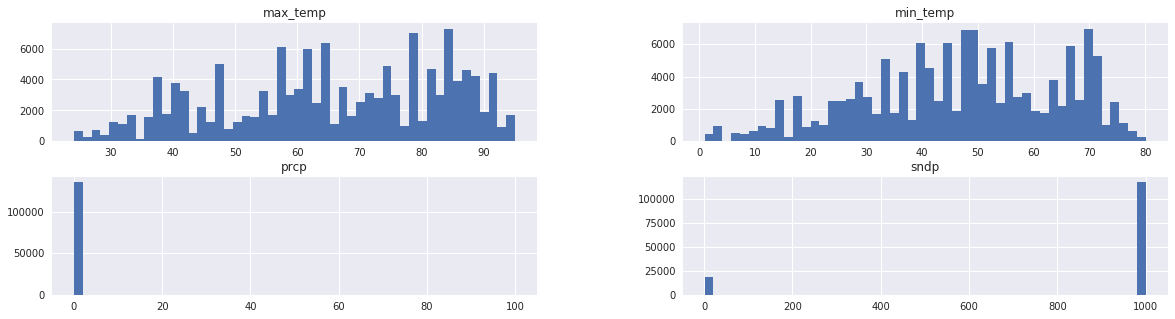

In [58]:
df_augmented[['min_temp','max_temp', 'prcp', 'sndp']].hist(figsize = (20,5), bins=50);

In [73]:
# prcp and sndp seem to have 2 classes. Manually encode them
df_augmented['prcp_class'] = np.where(df_augmented['prcp']>=90, 'rain', 'dry')
df_augmented['sndp_class'] = np.where(df_augmented['sndp']>=900, 'snow', 'dry')

In [78]:
y = df_augmented[['fare_amount', 'year']]
X = df_augmented[['passenger_count', 'trip_distance', 'trip_duration', 'year', 'month', 'day_of_week', 'hour_of_day', 'lat_dif', 'lon_dif', 'pickup_geohash', 'min_temp', 'max_temp', 'prcp_class', 'sndp_class']]
X_encoded = pd.get_dummies(X, columns=['month', 'day_of_week', 'hour_of_day', 'pickup_geohash', 'prcp_class', 'sndp_class'])

In [79]:
X_train, y_train, X_test, y_test = train_test_split(X_encoded, y)

In [80]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}
gbr = ensemble.GradientBoostingRegressor(**params)
gbr.fit(X_train, y_train)

model_results(X_train, y_train, X_test, y_test, gbr)

----Training Data results (2015 data set)----
RMSE: $3.9
R2: 0.90

----Test Data results (2016 data set)----
RMSE: $4.0
R2: 0.89



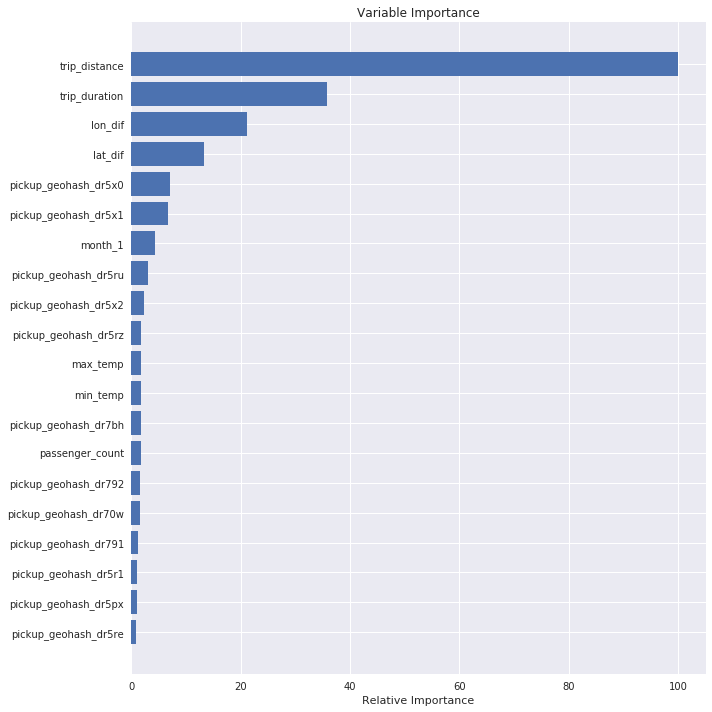

In [81]:
importances(X_train, gbr)

# Data Augmentation Results
- No difference in RMSE with additional weather features

# Hyperparameter tuning
- Try tuning hyperparameters to reduce RMSE

In [82]:
y = df_filtered[['fare_amount', 'year']]
X = df_filtered[['passenger_count', 'trip_distance', 'trip_duration', 'year', 'month', 'day_of_week', 'hour_of_day', 'lat_dif', 'lon_dif', 'pickup_geohash']]
X_encoded = pd.get_dummies(X, columns=['month', 'day_of_week', 'hour_of_day', 'pickup_geohash'])

In [83]:
X_train, y_train, X_test, y_test = train_test_split(X_encoded, y)

In [ ]:
# Hyper Parameter Tuning
from sklearn.model_selection import GridSearchCV
parameters = {
    'loss':['ls'],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 10],
    'max_depth':[2,4,8],
    'max_features':["log2","sqrt"],
    'criterion': ["friedman_mse",  "mae"],
    'subsample':[0.5, 0.8, 1.0],
    'n_estimators':[10, 100, 500]
    }

gbr_tuned = GridSearchCV(ensemble.GradientBoostingRegressor(), parameters, cv=5, n_jobs=4)
gbr_tuned.fit(X_train, y_train)

print(gbr_tuned.best_params_)

In [ ]:
model_results(X_train_encoded, y_train, X_test_encoded[mask], y_test[mask], gbr_tuned)